In [2]:
%cd ../

/Users/assiachericoni/Documents/PYTHON/ControllerModeling-main 3


In [ ]:
# load modules
from legacy.controllers import simulator as sim
from legacy.controllers import JaxMod as jm
import pandas as pd
import os
from legacy.controllers import utils as ut
from legacy.controllers.data import DataHandling as dh
from pathlib import Path
from sklearn.decomposition import PCA
import legacy.ChangeOfMind.functions.processing as proc
from legacy.PacTimeOrig.data import scripts
from scipy.io import loadmat, savemat
from scipy.stats import pearsonr
import numpy as np
import jax.numpy as jnp
import pandas as pd
from scipy.io import savemat
from legacy.PacTimeOrig.data import scripts
from joblib import Parallel, delayed
import argparse

/Users/assiachericoni/miniforge3/envs/ControllerPacman/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
results_path = '/Users/assiachericoni/Documents/PYTHON/ControllerModeling-main_old/PacManData'
results_path = Path(results_path)

In [5]:
# subj_list = ['BH001', 'BH002', 'BH003', 'BH006', 'BH007', 'BH008', 'BH009', 'BH010', 'BH011', 'BH012', 'BH013',
#             'BH014', 'BH015', 'BH016', 'BH017', 'BH018', 'BH019', 'BH020', 'BH021', 'BH022', 'BH023', 'BH024', 'BH025',
#             'BH026', 'BH027', 'BH028', 'BH029', 'BH030', 'BH031', 'BH032', 'BH033', 'BH034', 'BH040',
#             'MNA', 'MNB', 'MNC', 'MND', 'MNE', 'MNF', 'MNG', 'MNH', 'MNI', 'MNJ', 'MNK', 'MNL', 'MNM', 'MNN', 'MNO', 'MNP', 'MNQ']

#subj_list = ['MNA', 'MNB', 'MNC', 'MND', 'MNE', 'MNF', 'MNG', 'MNH', 'MNI', 'MNJ', 'MNK', 'MNL', 'MNM', 'MNN', 'MNO', 'MNP', 'MNQ']
# subj_list = ['YEJ', 'YEK', 'YEU', 'YEW', 'YEX', 'YEY', 'YEZ', 'YFA', 'YFB', 'YFC', 'YFD', 'YFE', 'YFF', 'YFP', 'YFQ', 'YFR', 'YFS', 'YFK', 'YFT']

subj_list = ['BH001', 'BH002', 'BH003', 'BH006', 'BH007', 'BH008', 'BH009', 'BH010', 'BH011', 'BH012', 'BH013',
             'BH014', 'BH015', 'BH016', 'BH017', 'BH018', 'BH019', 'BH020', 'BH021', 'BH022', 'BH023', 'BH024', 'BH025',
             'BH026', 'BH027', 'BH028', 'BH029', 'BH030', 'BH031', 'BH032', 'BH033', 'BH034', 'BH040',
             'MNA', 'MNB', 'MNC', 'MND', 'MNE', 'MNF', 'MNG', 'MNH', 'MNI', 'MNJ', 'MNK', 'MNL', 'MNM', 'MNN', 'MNO', 'MNP', 'MNQ', 
             'YEJ', 'YEK', 'YEU', 'YEW', 'YEX', 'YEY', 'YEZ', 'YFA', 'YFB', 'YFC', 'YFD', 'YFE', 'YFF', 'YFP', 'YFQ', 'YFR', 'YFS', 'YFK', 'YFT']


# subj_list = ['BH001', 'BH002', 'BH003', 'BH006', 'BH007', 'BH008', 'BH009', 'BH010', 'BH011', 'BH012', 'BH013',
#             'BH014', 'BH015', 'BH016', 'BH017', 'BH018', 'BH019', 'BH020', 'BH021', 'BH022', 'BH023', 'BH024', 'BH025',
#             'BH026', 'BH027', 'BH028', 'BH029', 'BH030', 'BH031', 'BH032', 'BH033', 'BH034', 'BH040']
 
base_dir = Path('/Users/assiachericoni/Documents/PYTHON/ControllerModeling-main_old/PacManData')

all_glm = []
for subj in subj_list:
    glm_path = base_dir / subj / 'GLM_data_filtered2.csv'
    if glm_path.exists():
        df = pd.read_csv(glm_path)
        df['subject'] = subj                # ensure subject is tagged
        all_glm.append(df)
    else:
        print(f"Warning: {glm_path} not found, skipping.")

# Combine data from all subjects in a unique dataframe
GLM_data_all = pd.concat(all_glm, ignore_index=True)

In [6]:
# continue formatting glm data
GLM_data = GLM_data_all
GLM_data['ismonkey'] = 0
#GLM_data.val_diff = GLM_data.val_high - GLM_data.val_low
GLM_data = proc.clean_behave_regress(GLM_data)

# remove rows with non-int direction
GLM_data = GLM_data.dropna(subset=['direction'])
GLM_data = GLM_data.drop(columns=['direction'])

#GLM_data['direction'] = pd.to_numeric(GLM_data['direction']).astype(int)

In [7]:
# Step 1: Recompute val_diff as val_hi - val_lo
GLM_data['val_diff'] = GLM_data['val_high'] - GLM_data['val_low']

# Step 2: Replace val_diff = 1 with 2, and val_diff = 3 with 4
GLM_data['val_diff'] = GLM_data['val_diff'].replace({1: 0, 3: 4})

# Step 3: Normalize val_diff by dividing by 4
#GLM_data['val_diff'] = GLM_data['val_diff'] / 4


In [8]:
# Extract % of switches
switch_col = 'real_1_control_0'

# Overall percentage of legitimate switches
total_switches = (GLM_data[switch_col] == 1).sum()
total_rows = len(GLM_data_all)
overall_percent = 100 * total_switches / total_rows
print(f"Overall % of legitimate switches: {overall_percent:.2f}%")

# Per-subject percentage
percent_per_subject = (
    GLM_data_all.groupby('subject')[switch_col]
    .mean() * 100
).reset_index()
percent_per_subject.columns = ['subject', 'percent_switches']
print(percent_per_subject)


Overall % of legitimate switches: 41.17%
   subject  percent_switches
0    BH001         54.482759
1    BH002         65.408805
2    BH003         57.553957
3    BH006         60.000000
4    BH007         60.797342
..     ...               ...
64     YFP         18.309859
65     YFQ         28.888889
66     YFR         29.069767
67     YFS         35.555556
68     YFT         22.784810

[69 rows x 2 columns]


In [9]:
# Number of switches per ΔR level
switch_counts = GLM_data[GLM_data['real_1_control_0'] == 1].groupby('val_diff').size()
total_counts = GLM_data.groupby('val_diff').size()
switch_rate = 100 * switch_counts / total_counts


In [10]:
switch_pct_overall = (
    GLM_data.groupby('val_diff')['real_1_control_0']
    .mean()
    .reset_index()
    .rename(columns={'real_1_control_0': 'switch_rate_overall'})
)

switch_pct_by_subject = (
    GLM_data.groupby(['subject', 'val_diff'])['real_1_control_0']
    .mean()
    .reset_index()
    .rename(columns={'real_1_control_0': 'switch_rate'})
)

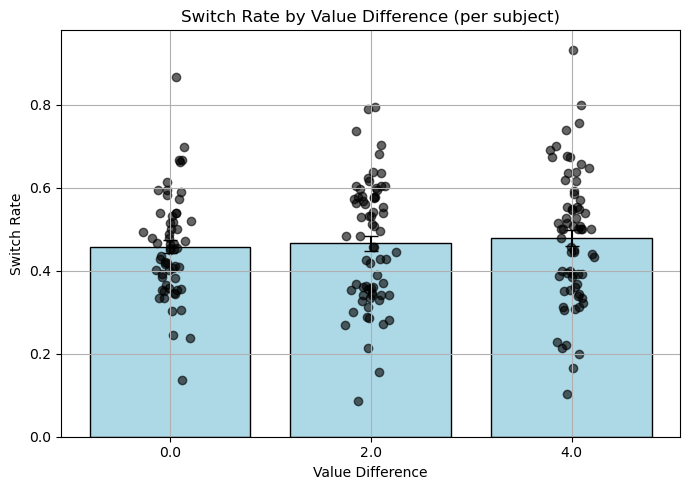

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Group by val_diff to get mean and SEM
summary = switch_pct_by_subject.groupby('val_diff')['switch_rate'].agg(['mean', 'sem']).reset_index()

# Create the figure
fig, ax = plt.subplots(figsize=(7, 5))

# Bar plot with error bars
x = np.arange(len(summary))
ax.bar(x, summary['mean'], yerr=summary['sem'], capsize=5, color='lightblue', edgecolor='black')

# Overlay individual subject data
for i, val in enumerate(summary['val_diff']):
    y = switch_pct_by_subject[switch_pct_by_subject['val_diff'] == val]['switch_rate'].values
    jitter = np.random.normal(0, 0.05, size=len(y))  # horizontal jitter
    ax.scatter(x[i] + jitter, y, color='black', alpha=0.6)

# Tidy up
ax.set_xticks(x)
ax.set_xticklabels(summary['val_diff'])
ax.set_xlabel('Value Difference')
ax.set_ylabel('Switch Rate')
ax.set_title('Switch Rate by Value Difference (per subject)')
ax.grid(True)
plt.tight_layout()

# Save as SVG
save_path = "/Users/assiachericoni/Documents/PYTHON/ControllerModeling-main_old/PacManData/figures_cumulative/switch_rate_by_val_diff_ALLFinal.svg"
plt.savefig(save_path, format='svg', bbox_inches='tight')

plt.show()


In [12]:
# Clip extreme values to reduce variance inflation from outliers
#clip_limits = {
#    'timing': (-5, 5),
#    'switch_to_speed_mean': (-5, 5),
#    'switch_to_speeed_mean': (-5, 5),  # typo in name, included just in case
#    'switch_away_speed_mean': (-5, 5),
#    'switch_to_dist_mean': (-5, 5),
#    'switch_away_dist_mean': (-5, 5),
#   'switch_to_dist_slope': (-5, 5),
#    'switch_away_dist_slope': (-5, 5),
#    'switch_to_speed_slope': (-5, 5),
#    'switch_away_speed_slope': (-5, 5)
#}

#for var, (vmin, vmax) in clip_limits.items():
#    if var in GLM_data.columns:
#        GLM_data[var] = GLM_data[var].clip(lower=vmin, upper=vmax)


In [13]:
from statsmodels.genmod.bayes_mixed_glm import BayesMixedGLMResults
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

Y = GLM_data['real_1_control_0']

Y = Y.astype(float).astype(int)
design_matrix = proc.glm_model_behavior_design_matrix(GLM_data, construction='full')
design_matrix = design_matrix.drop(columns='Intercept')
design_matrix['y']=Y
design_matrix['subject']=GLM_data['subject']

In [14]:
# get formulas
formulas = proc.glm_model_behavior_design_matrix(GLM_data, construction='cv')
# Define fixed effects formula
fixed_formula='y~'+formulas['Main effects only']
random_formula = {'subject': '0 + C(subject)'}

form=fixed_formula

# Extract the main effect terms (everything except 'y ~')
main_effects = form.split('~')[1].strip().split(' + ')

# Define the variables of interest
val_diff = 'val_diff'

# Generate second-order interactions
second_order_with_val_diff = [f"{val_diff}:{term}" for term in main_effects if term not in (val_diff, 'y')]

# Generate third-order interactions between val_diff and other variables
third_order_with_val_diff_and_direction = [
    f"{val_diff}:{term}" for term in main_effects if term not in (val_diff, 'y')
]

# Combine everything: main effects, second-order
fixed_formula = (
        'y ~ ' +
        ' + '.join(main_effects) +
        ' + ' +
        ' + '.join(second_order_with_val_diff)
)

In [15]:
# run model
model = BinomialBayesMixedGLM.from_formula(fixed_formula, random_formula, design_matrix)
result = model.fit_vb()
fixed_effects=result.fe_mean
fixed_effects_sd=result.fe_sd

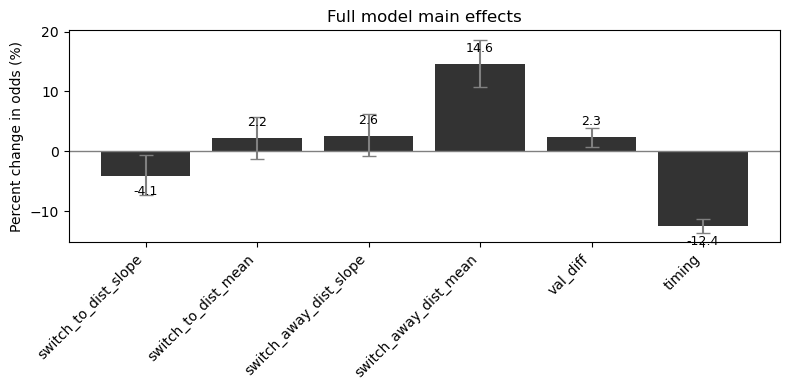

In [16]:
beta   = result.fe_mean          # log-odds coefficients
se_log = result.fe_sd            # their posterior SD on log-odds

# 1) compute 95% CI on the log-odds scale
lower_log = beta - 1.96 * se_log
upper_log = beta + 1.96 * se_log

# 2) back‐transform to odds–ratio scale
OR       = np.exp(beta)
OR_low   = np.exp(lower_log)
OR_high  = np.exp(upper_log)

# 3) convert to “percent change in odds”
pt      = 100 * (OR     - 1)
err_lo  = 100 * (OR     - OR_low)
err_hi  = 100 * (OR_high - OR)

# 4) slice out the first six (skip intercept) and plot
target_vars = [
    'switch_to_dist_slope',
    'switch_to_dist_mean',
    'switch_away_dist_slope',
    'switch_away_dist_mean',
    'val_diff',
    'timing'
]
idx = [model.exog_names.index(var) for var in target_vars]

#idx     = np.arange(1,7)
x       = np.arange(1,7)
labels  = [model.exog_names[i] for i in idx]

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar    (x, pt[idx],         color='k', alpha=0.8)
plt.errorbar(x, pt[idx], yerr=[err_lo[idx], err_hi[idx]],
             fmt='none', ecolor='gray', capsize=5)
for xi, yi in zip(x, pt[idx]):
    va = 'bottom' if yi >= 0 else 'top'
    offset = 1.5 if yi >= 0 else -1.5  # spacing in percent units
    plt.text(xi, yi + offset, f'{yi:.1f}',
             ha='center', va=va, fontsize=9)

plt.axhline(0, color='gray', lw=1)
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('Percent change in odds (%)')
plt.title ('Full model main effects')
plt.tight_layout()
plt.savefig(results_path / "GLM_behave_coeff_mainEffects_ALLNEW.png",
            transparent=True, bbox_inches='tight', dpi=300)
plt.show()

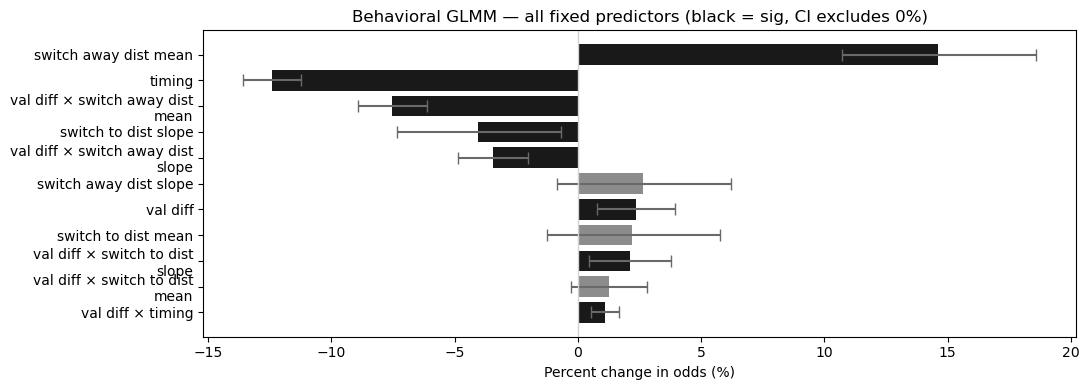

n_terms: 11   original: 12


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

# --- pull from the fitted result to avoid mismatches ---
beta   = np.asarray(result.fe_mean)   # log-odds
se_log = np.asarray(result.fe_sd)
names  = np.asarray(result.model.exog_names)  # fixed-effect column names

# hard guard: trim to the common length if something is off
k = min(len(beta), len(se_log), len(names))
beta, se_log, names = beta[:k], se_log[:k], names[:k]

# 95% CI on log-odds
lower_log = beta - 1.96 * se_log
upper_log = beta + 1.96 * se_log

# to odds-ratio and % change in odds
OR      = np.exp(beta)
OR_low  = np.exp(lower_log)
OR_high = np.exp(upper_log)

pct    = 100 * (OR - 1)
err_lo = 100 * (OR - OR_low)
err_hi = 100 * (OR_high - OR)

# build table, drop Intercept if present
df = pd.DataFrame({
    "term": names,
    "beta_logodds": beta,
    "pct": pct,
    "err_lo": err_lo,
    "err_hi": err_hi,
    "OR_low": OR_low,
    "OR_high": OR_high
})
df = df[df["term"] != "Intercept"].copy()

# significance (CI on OR not crossing 1)
df["sig"] = (df["OR_low"] > 1) | (df["OR_high"] < 1)

# pretty labels
def wrap_label(s):
    s = s.replace(":", " × ").replace("_", " ")
    return "\n".join(textwrap.wrap(s, width=28))

df["label"] = df["term"].map(wrap_label)

# order by |effect| (small→top, big→bottom)
df = df.reindex(df["pct"].abs().sort_values(ascending=True).index)

fig_h = max(4, 0.35 * len(df))
plt.figure(figsize=(11, fig_h))
ypos   = np.arange(len(df))
colors = np.where(df["sig"], "black", "gray")

plt.barh(ypos, df["pct"], color=colors, alpha=0.9)

xerr = np.vstack([df["err_lo"].values, df["err_hi"].values])
plt.errorbar(df["pct"], ypos, xerr=xerr, fmt='none', ecolor='dimgray', capsize=4, capthick=1)

plt.axvline(0, color='lightgray', lw=1)
plt.yticks(ypos, df["label"])
plt.xlabel("Percent change in odds (%)")
plt.title("Behavioral GLMM — all fixed predictors (black = sig, CI excludes 0%)")
plt.tight_layout()

# Save as SVG
save_path = "/Users/assiachericoni/Documents/PYTHON/ControllerModeling-main_old/PacManData/figures_cumulative/GLM_behave_coeff_ALL_fixed_ALL.svg"
plt.savefig(save_path, format='svg', transparent=True, bbox_inches='tight')

plt.show()

# (optional) quick sanity print to confirm lengths matched
print("n_terms:", len(df), "  original:", len(names))


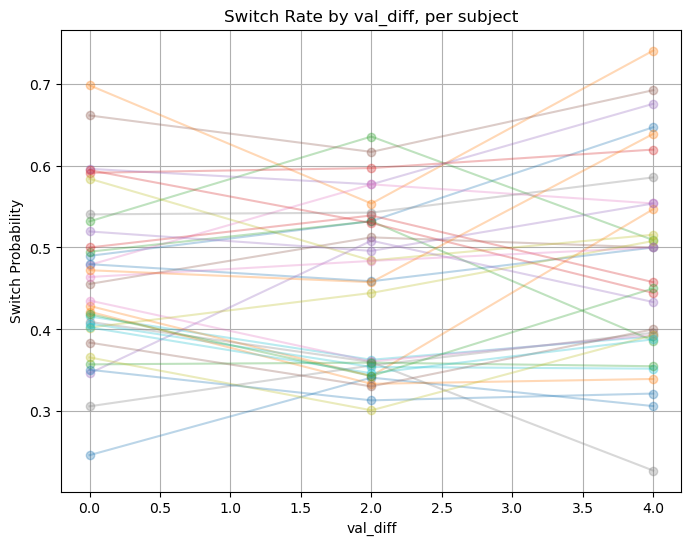

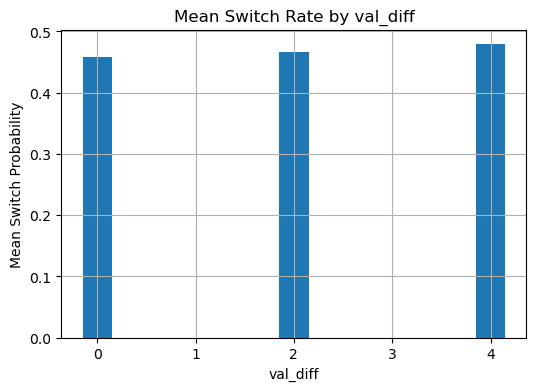

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

grouped = GLM_data.groupby(['subject', 'val_diff']).agg(
    n_trials=('real_1_control_0', 'count'),
    n_switches=('real_1_control_0', 'sum')
).reset_index()
grouped['switch_rate'] = grouped['n_switches'] / grouped['n_trials']

plt.figure(figsize=(8,6))
for subj in grouped['subject'][0:99,].unique(): #with 99 takes only our subjects - no minnesota
    subj_data = grouped[grouped['subject'] == subj]
    plt.plot(subj_data['val_diff'], subj_data['switch_rate'], marker='o', alpha=0.3)
plt.xlabel('val_diff')
plt.ylabel('Switch Probability')
plt.title('Switch Rate by val_diff, per subject')
plt.grid(True)

# Save as SVG
save_path = "/Users/assiachericoni/Documents/PYTHON/ControllerModeling-main_old/PacManData/figures_cumulative/switch_prob_by_sbj_ALL.svg"
plt.savefig(save_path, format='svg', transparent=True, bbox_inches='tight')


plt.show()

# And to plot across all subjects (mean switch rate):
mean_switch = grouped.groupby('val_diff')['switch_rate'].mean()
plt.figure(figsize=(6,4))
plt.bar(mean_switch.index, mean_switch.values, width=0.3)
plt.xlabel('val_diff')
plt.ylabel('Mean Switch Probability')
plt.title('Mean Switch Rate by val_diff')
plt.grid(True)
save_path = "/Users/assiachericoni/Documents/PYTHON/ControllerModeling-main_old/PacManData/figures_cumulative/switch_prob_by_sbj_ALL.svg"
plt.savefig(save_path, format='svg', transparent=True, bbox_inches='tight')

plt.show()

In [19]:
# 1. Extract subject-level variance (assumed to be the first and only variance component)
subject_var = result.vcp_mean[0]
subject_sd = np.sqrt(subject_var)

# 2. Residual variance for logistic models (standard assumption)
residual_var = np.pi**2 / 3

# 3. Compute ICC (intra-class correlation coefficient)
icc = subject_var / (subject_var + residual_var)

# 4. Print results
print(f"Subject-level SD: {subject_sd:.3f}")
print(f"Subject-level Variance: {subject_var:.3f}")
print(f"Residual Variance (logit link): {residual_var:.3f}")
print(f"Intraclass Correlation Coefficient (ICC): {icc:.3f}")

print("Class balance:\n", design_matrix['y'].value_counts(normalize=True).rename('proportion'))

num_cols = [c for c in design_matrix.columns if c not in ['y','subject']]
desc = design_matrix[num_cols + ['y']].describe().T
print("\nPredictor summary (first 10 rows):")
print(desc.head(10))


Subject-level SD: nan
Subject-level Variance: -0.705
Residual Variance (logit link): 3.290
Intraclass Correlation Coefficient (ICC): -0.273
Class balance:
 y
0    0.523396
1    0.476604
Name: proportion, dtype: float64

Predictor summary (first 10 rows):
                                 count      mean       std        min  \
switch_to_dist_slope           13357.0  0.007550  1.009985  -3.986874   
switch_to_dist_mean            13357.0  0.013337  1.023878  -2.225467   
switch_away_dist_slope         13357.0 -0.011474  1.026862  -5.281164   
switch_away_dist_mean          13357.0 -0.014157  1.023764  -4.289237   
val_diff                       13357.0  1.693195  1.517659   0.000000   
timing                         13357.0  0.363619  2.736119  -9.151830   
switch_to_dist_slope:val_diff  13357.0  0.012096  2.171553 -11.922506   
switch_to_dist_slope:timing    13357.0 -0.144834  2.657230 -34.521485   
switch_to_dist_mean:val_diff   13357.0 -0.059030  2.318864  -8.901870   
switch_to_dist_

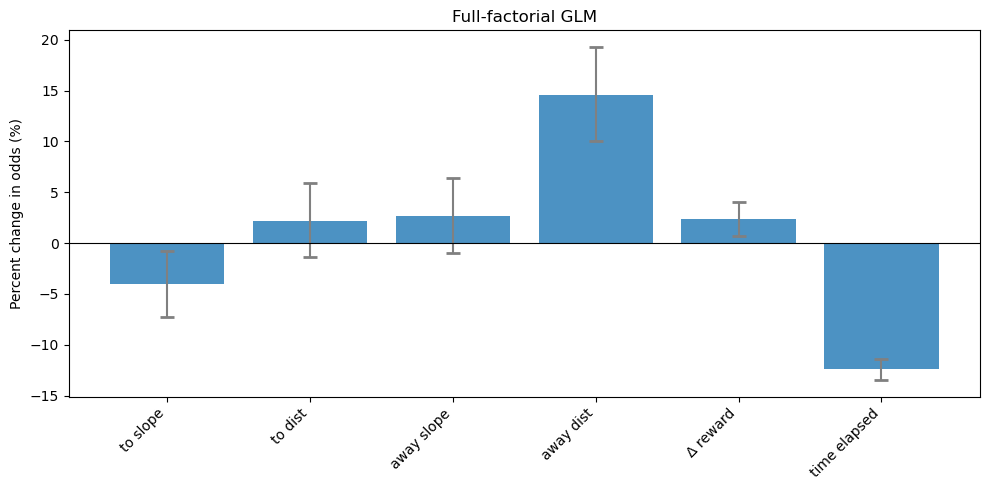

In [20]:
# How it was in Justin's code
fixed_effects_sd=np.exp(fixed_effects)*fixed_effects_sd
# Compute 95% posterior intervals for fixed effects and set 0 otherwise
lower_bound = np.exp(fixed_effects - 2.0 * fixed_effects_sd)-1
upper_bound = np.exp(fixed_effects + 2.0 * fixed_effects_sd)-1
issig = (np.sign(lower_bound) * np.sign(upper_bound))
pt=np.exp(fixed_effects)-1
# pt[issig < 0]=0
# Calculate error bars (distance from estimate to bounds)
error_bars = [pt - lower_bound, upper_bound - pt]
error_bars[0] = 100*error_bars[0][1:7]
error_bars[1] = 100*error_bars[1][1:7]

# 1) choose the slice of columns you’re plotting
cols = design_matrix.columns[0:6]

# 2) build a dict of “raw name” → “pretty label”
pretty = {
    'switch_to_dist_slope'      : 'to slope',
    'switch_to_dist_mean'       : 'to dist',
    'switch_away_dist_slope'    : 'away slope',
    'switch_away_dist_mean'     : 'away dist',
    'val_diff'                  : 'Δ reward',
    'timing'                    : 'time elapsed'    # …etc, fill in the rest if you care to plot interaction terms…
}

# 3) build your list of tick‐labels
tick_labels = [ pretty.get(c, c) for c in cols ]

# 4) now plot exactly as before but inject your nicer labels
plt.figure(figsize=(10,5))

# bar from x=1..15
x = np.arange(1, 7)
plt.bar(x, 100*pt[1:7], alpha=0.8)

plt.errorbar(
    x, 100*pt[1:7],
    yerr=error_bars,
    fmt='none',
    ecolor='gray',
    capsize=5,
    capthick=2
)

folder = results_path 

plt.axhline(0, color='k', linewidth=0.8)

plt.xticks(x, tick_labels, rotation=45, ha='right')
plt.ylabel('Percent change in odds (%)')
plt.title('Full‐factorial GLM')
output_file = folder / "GLM_behave_coeff_GLMM_bayes_ALL.png"

plt.tight_layout()
plt.savefig(output_file, transparent=True, bbox_inches='tight', dpi=300)
plt.show()

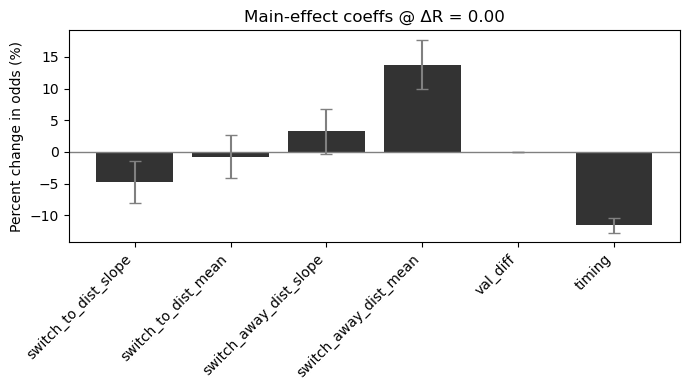

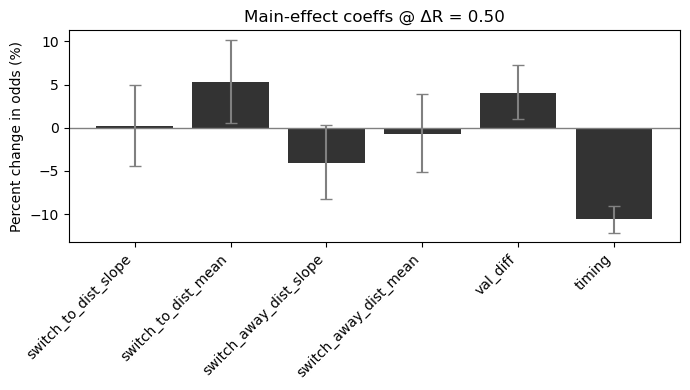

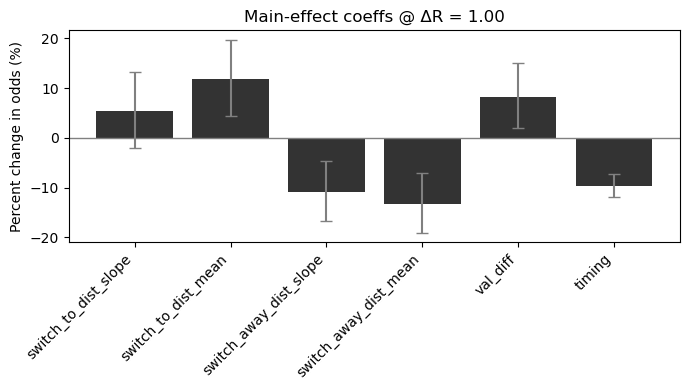

In [20]:
# marginalize according to reward difference
import numpy as np
import matplotlib.pyplot as plt

names = model.exog_names
β     = result.fe_mean
σ     = result.fe_sd

# pick out your six “pure” main predictors in the paper’s order:
main_preds = [
 'switch_to_dist_slope',
 'switch_to_dist_mean',
 'switch_away_dist_slope',
 'switch_away_dist_mean',
 'val_diff',
 'timing',
]


def find_interaction(pred, mod_names):
    """Find the index of the two-way interaction between pred and 'val_diff'."""
    for i, nm in enumerate(mod_names):
        parts = nm.split(':')
        if set(parts) == {pred, 'val_diff'}:
            return i
    return None

for deltaR in [0.0, 0.5, 1.0]:
    heights = []
    err_lo  = []
    err_hi  = []
    for pred in main_preds:
        # build a contrast vector
        x = np.zeros_like(β)
        # 1) pick out the pure main effect
        idx_main = names.index(pred)
        x[idx_main] = 1.0

        # 2) add deltaR * the val_diff interaction (if it exists)
        i_int = find_interaction(pred, names)
        if i_int is not None:
            x[i_int] = deltaR

        # get posterior mean & SD on log-odds
        μ  = x.dot(β)
        sd = np.sqrt( np.sum((x*σ)**2) )

        # 95% CI on log-odds
        lo_log, hi_log = μ - 1.96*sd, μ + 1.96*sd

        # back-transform to OR
        OR    = np.exp(μ)
        OR_lo = np.exp(lo_log)
        OR_hi = np.exp(hi_log)

        # convert to % change in odds
        heights.append(100*(OR    - 1))
        err_lo .append(100*(OR    - OR_lo))
        err_hi .append(100*(OR_hi - OR))

    # now plot
    xpos = np.arange(len(main_preds))
    plt.figure(figsize=(7,4))
    plt.bar    (xpos, heights, color='k', alpha=0.8)
    plt.errorbar(xpos, heights,
                 yerr=[err_lo, err_hi],
                 fmt='none', ecolor='gray', capsize=4)
    plt.axhline(0, color='gray', lw=1)
    plt.xticks(xpos, main_preds, rotation=45, ha='right')
    plt.ylabel('Percent change in odds (%)')
    plt.title (f'Main-effect coeffs @ ΔR = {deltaR:.2f}')
    plt.tight_layout()
    plt.show()



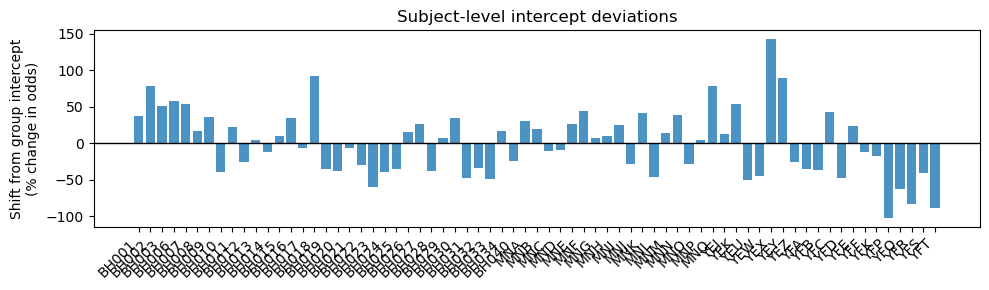

In [21]:
# see inter-subject variability - propensity to switch in respect to baseline value - so here we look at the random effects subject variable (uj - beta0)
import patsy

# 1) Rebuild the random‐effects design to get the subject list in order
vc_df = patsy.dmatrix("0 + C(subject)", data=GLM_data, return_type="dataframe") # create a desogn matrix for each subj with intercept = 0 
subjects_vc = [col.split("[")[1].rstrip("]") for col in vc_df.columns]
J = len(subjects_vc)

# 2) Pull out the raw random-effects vector and reshape into (J, fe_p)
u_raw = result.random_effects()           # this comes back as a flat array length J*fe_p
fe_p = u_raw.size // J
u_mat = np.asarray(u_raw).reshape(J, fe_p)

# 3) The intercept shift is the **first** column
u_intercept = u_mat[:, 0]

# 4) Grab the fixed‐effect intercept β0
β0 = result.fe_mean[0]

# 5) Build a DataFrame and compute “intercept_plus”
df_re = pd.DataFrame({
    "subject":         subjects_vc,
    "intercept_shift": u_intercept,          # u_j in log-odds
})
df_re["intercept_plus"] = β0 + df_re["intercept_shift"]

# 6) Plot each subject’s intercept shift (×100 for % change in odds)
fig, ax = plt.subplots(figsize=(10, 3), dpi=100)
x = np.arange(J)

ax.bar(x, df_re["intercept_shift"] * 100, color="C0", alpha=0.8)
ax.axhline(0, color="k", lw=1)

ax.set_xticks(x)
ax.set_xticklabels(df_re["subject"], rotation=45, ha="right")
ax.set_ylabel("Shift from group intercept\n(% change in odds)")
ax.set_title("Subject-level intercept deviations")

plt.tight_layout()
plt.show()




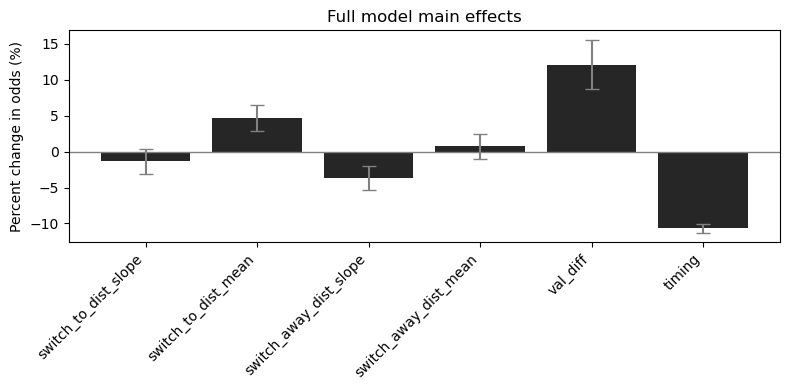

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

fixed_terms = [
    'switch_to_dist_slope','switch_to_dist_mean',
    'switch_away_dist_slope','switch_away_dist_mean',
    'val_diff','timing'
]
fixed_formula  = 'real_1_control_0 ~ ' + ' + '.join(fixed_terms)
random_formula = {'subject': '0 + C(subject)'}  # random intercept

model  = BinomialBayesMixedGLM.from_formula(fixed_formula, random_formula, GLM_data)
res    = model.fit_vb()

names = model.exog_names
b     = res.fe_mean
se    = res.fe_sd

rows=[]
for term in fixed_terms:
    i = names.index(term)
    bi, sei = b[i], se[i]

    # center value: percent change in odds
    OR  = np.exp(bi)
    pct = 100*(OR-1)

    # OPTION 1: 68% interval (±1 SD on log-odds, exact transform)
    lo68 = np.exp(bi - 1.0*sei); hi68 = np.exp(bi + 1.0*sei)
    err_lo_68 = 100*(OR - lo68)
    err_hi_68 = 100*(hi68 - OR)

    # OPTION 2: delta-method SE on %change (symmetric, usually smaller)
    # var(OR) ≈ (OR^2) * var(beta); so SD(%change) ≈ 100 * OR * se
    sd_pct = 100 * OR * sei

    rows.append((term, pct, err_lo_68, err_hi_68, sd_pct))

df = pd.DataFrame(rows, columns=['term','pct','err_lo_68','err_hi_68','sd_pct'])

# --- choose which error bars to plot ---
use = '68'   # '68' for 68% interval, or 'delta' for ±1 SD on % change

yerr = np.vstack([df['err_lo_68'], df['err_hi_68']]) if use=='68' else df['sd_pct'].values

x = np.arange(len(df))
plt.figure(figsize=(8,4))
plt.bar(x, df['pct'], color='k', alpha=0.85)
plt.errorbar(x, df['pct'], yerr=yerr, fmt='none', ecolor='gray', capsize=5)
plt.axhline(0, color='gray', lw=1)
plt.xticks(x, df['term'], rotation=45, ha='right')
plt.ylabel('Percent change in odds (%)')
plt.title('Full model main effects')
plt.tight_layout()
plt.show()
